# Spatially varying parameters 1

In this tutorial, we explore different ways of defining a spatially varying parameter. As an example, we use the  Zeeman energy term.

### Spatially constant $\mathbf{H}$

Let us start by assembling a simple simulation where $\mathbf{H}$ does not vary in space. The sample is a "one-dimensional" chain of magnetic moments.

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

p1 = (-10e-9, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

The system has an energy equation, which consists of only Zeeman energy term.

In [2]:
H = (0, 0, 1e6)  # external magnetic field (A/m)
system = mm.System(name="zeeman_constant_H")
system.energy = mm.Zeeman(H=H)

We are going to minimise the system's energy using `oommfc.MinDriver` later. Therefore, we do not have to define the system's dynamics equation. Finally, we need to define the system's magnetisation (`system.m`). We are going to make it random with $M_\text{s}=8\times10^{5} \,\text{Am}^{-1}$

In [3]:
import random
import discretisedfield as df

Ms = 8e5  # saturation magnetisation (A/m)


def m_fun(pos):
    return [2 * random.random() - 1 for i in range(3)]


system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

The magnetisation, we set is

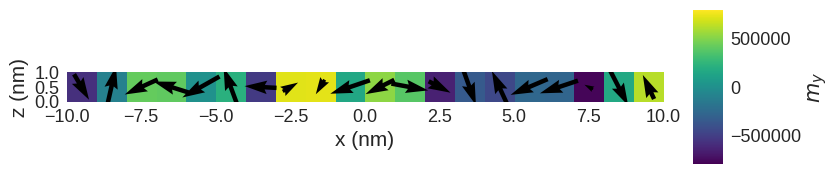

In [4]:
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)

Now, we can minimise the system's energy by using `oommfc.MinDriver`.

In [5]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:07]... (0.3 s)


We expect that now all magnetic moments are aligned parallel to the external magnetic field (in the $z$-direction).

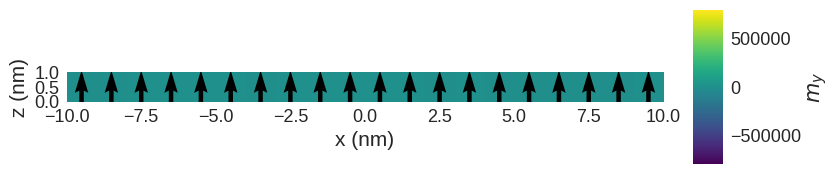

In [6]:
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)

### Spatially varying H

There are two different ways how a parameter can be made spatially varying, by using:

1. Dictionary
2. `discretisedfield.Field`

**Dictionary**

In order to define a parameter using a dictionary, subregions must be defined in the mesh. Subregions are defined as a dictionary, whose keys are the strings and values are `discretisedfield.Region` objects, which take two corner points of the region as input parameters. 

In [7]:
p1 = (-10e-9, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
subregions = {
    "subregion1": df.Region(p1=(-10e-9, 0, 0), p2=(0, 1e-9, 1e-9)),
    "subregion2": df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9)),
}

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, subregions=subregions)

Let us say we want to apply the external magnetic field $\mathbf{H}$ in region 1 in the $x$-direction and in region 2 in the negative $z$-direction. `H` is now defined as a dictionary:

In [8]:
H = {"subregion1": (1e6, 0, 0), "subregion2": (0, 0, -1e6)}

The system object is

In [9]:
system = mm.System(name="zeeman_dict_H")
system.energy = mm.Zeeman(H=H)
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

Its magnetisation is

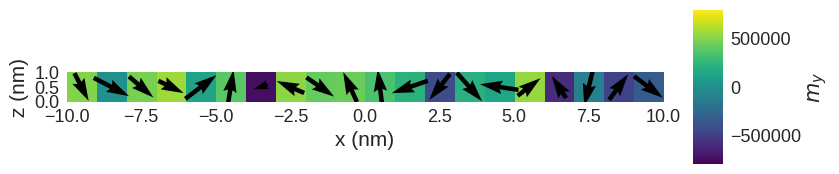

In [10]:
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)

After we minimise the energy

In [11]:
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:07]... (0.2 s)


The magnetisation is as we expected.

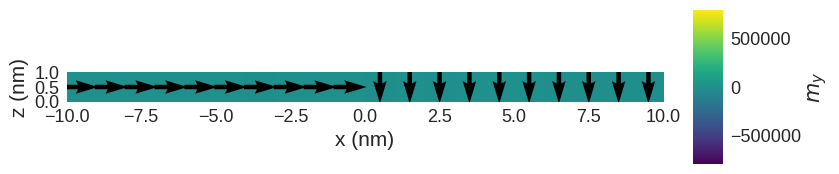

In [12]:
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)

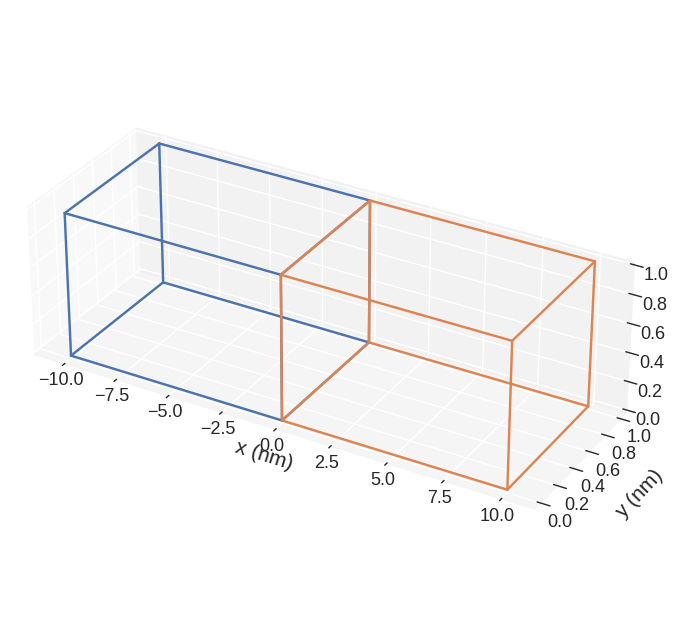

In [13]:
mesh.mpl.subregions(box_aspect=(10, 3.5, 3), figsize=(8, 8))

**`discretisedfield.Field`**

Let us say that the external magnetic field varies in space as

$$\mathbf{H}(x, y, z) = (c^{2}x, 0, c)$$

where $c=10^{9}$ and the entire field is normalised with $H = 10^{6} \,\text{Am}^{-1}$. The value of a spatially varying field is set using a Python function.

In [14]:
def H_fun(point):
    x, y, z = point
    c = 1e9
    return (c * c * x, 0, c)

The external magnetic field is

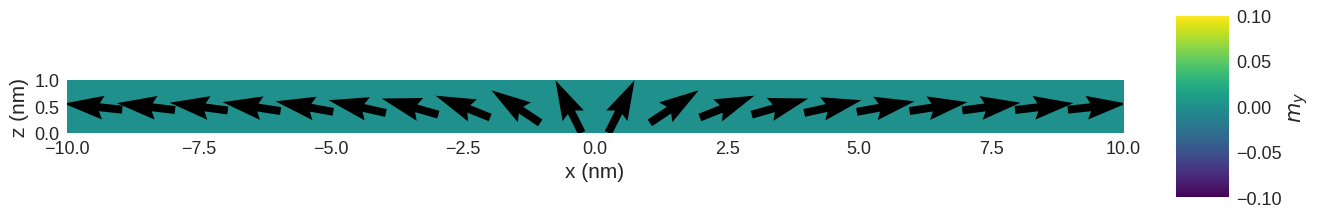

In [15]:
H = df.Field(mesh, nvdim=3, value=H_fun, norm=1e6)
H.sel("y").mpl(figsize=(15, 3), scalar_kw={"colorbar_label": "$m_y$"})

The system is

In [16]:
system = mm.System(name="zeeman_field_H")
system.energy = mm.Zeeman(H=H)
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

and its magnetisation is

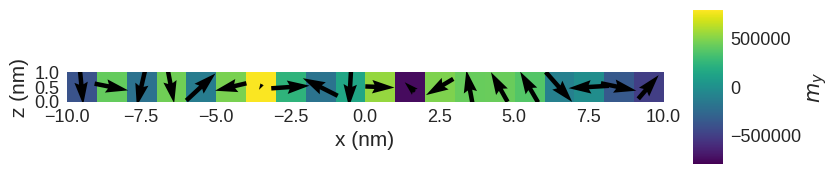

In [17]:
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)

After the energy minimisation, the magnetisation is:

Running OOMMF (ExeOOMMFRunner)[2023/10/23 16:07]... (0.2 s)


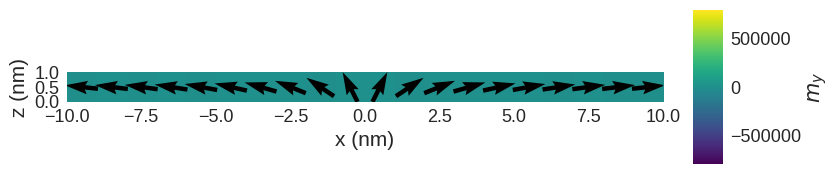

In [18]:
md.drive(system)
system.m.sel("y").mpl(
    scalar_kw={"colorbar_label": "$m_y$", "clim": (-Ms, Ms)}, figsize=(10, 2)
)